# Train NN

This notebook is used for testing and running model fitting pipelines defined in `train_nn.py`.

It's run in the `train_nn` conda environment instead of the usual `nnn` environment.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
import json, os, pickle
from collections import defaultdict
import nupack
import sklearn
from scipy import stats


from tqdm import tqdm
import itertools

from nnn import util, fileio, mupack, plotting, modeling
import nnn.motif_fit as mf
import wandb

# suppress warnings 
import warnings
warnings.filterwarnings("ignore")

from nnn import train_nn as tnn

## *dna24*

Config for the 178 param model used to make *dna24*:

In [2]:
"""
Config for the 178 param model used to make *dna24*
"""
fixed_pclass = ['hairpin_size', 'interior_size', 'bulge_size', 'hairpin_triloop', 'hairpin_tetraloop', 'terminal_mismatch', 'stack']
config = dict(
    use_train_set_ratio = 1.,
    secondary_struct = 'target', # target uses the designed structures, mfe uses the predicted mfe structures
    fit_method = 'svd',
    feature_method = 'get_nupack_feature_list',
    fit_intercept=False, 
    symmetry=False,
    fix_some_coef=True,
    fixed_pclass = fixed_pclass,
    test_mode = 'test', # {'val', 'test'}
    use_model_from = 'json', # {'lr_dict', 'json'}
    )

Run model training only:

wandb: Currently logged in as: keyuxi. Use `wandb login --relogin` to force relogin


feats (30872, 185) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#7', 'hairpin_size#8', 'hairpin_size#9', 'hairpin_size#10', 'hairpin_size#11', 'hairpin_size#12', 'hairpin_size#13', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'hairpin_size#23', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
rank 152
shape of A_unknown (24689, 152)
rank 152
shape of A_unknown (24689, 152)

Template file: ./models/dna04.json
Centering new parameters...
group bulge_size
Nothing happened.

group hairpin_mismatch
	Mean value of old_dict is -3.684
	Mean value of fitted new_dict is -13.355
	Mean value of centered new_dict is -3.684

group hairpin_size
N

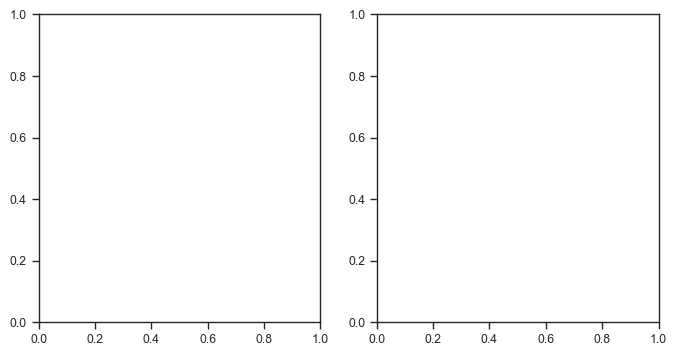

In [4]:
lr_dict_1pass = tnn.train(config)
dH_coef, dG_coef = lr_dict_1pass['dH'].coef_df, lr_dict_1pass['dG'].coef_df

Run the entire model training and testing pipeline:

In [11]:
wandb.config

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
n_feat,185
n_fixed_feat,33
param_set_file,./models/glorious-sn...
train_dG_mae,0.60934
train_dG_rsqr,0.62676


feats (30872, 185) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#7', 'hairpin_size#8', 'hairpin_size#9', 'hairpin_size#10', 'hairpin_size#11', 'hairpin_size#12', 'hairpin_size#13', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'hairpin_size#23', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
rank 152
shape of A_unknown (24689, 152)
rank 152
shape of A_unknown (24689, 152)

Template file: ./models/dna04.json
Centering new parameters...
group bulge_size
Nothing happened.

group hairpin_mismatch
	Mean value of old_dict is -3.684
	Mean value of fitted new_dict is -13.355
	Mean value of centered new_dict is -3.684

group hairpin_size
N

Traceback (most recent call last):
  File "/Users/yuxi/workspace/nnn_paper/nnn/train_nn.py", line 24, in model_pipeline
    test(config, json_file=json_file)
  File "/Users/yuxi/workspace/nnn_paper/nnn/train_nn.py", line 283, in test
    val_result_df_dict[dataset_name] = modeling.make_model_validation_df(
  File "/Users/yuxi/workspace/nnn_paper/nnn/modeling.py", line 26, in make_model_validation_df
    pred_df = get_model_prediction(df=val_data_df, **pred_kwargs)
  File "/Users/yuxi/workspace/nnn_paper/nnn/modeling.py", line 83, in get_model_prediction
    result_df = globals()[f'run_{model}'](seq_list, struct_list, sodium, model_param_file, model_kwargs)
  File "/Users/yuxi/workspace/nnn_paper/nnn/modeling.py", line 199, in run_nupack
    Tm = util.calculate_tm(seq, struct,
  File "/Users/yuxi/workspace/nnn_paper/nnn/util.py", line 535, in calculate_tm
    Q_K = calculate_distance_2_equilibrium(seq, DNA_conc, get_nupack_model(T), target_struct=target_struct)
  File "/Users/yuxi/works

KeyboardInterrupt: 

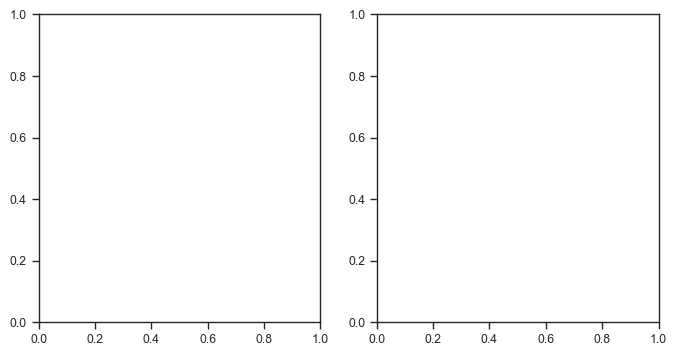

In [10]:
tnn.model_pipeline(config)

## Run models with different ratio of training data

In [6]:
# Set the range of ratio of training data used here
myrange = np.logspace(-2, 0,num=10)
myrange

array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])

feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


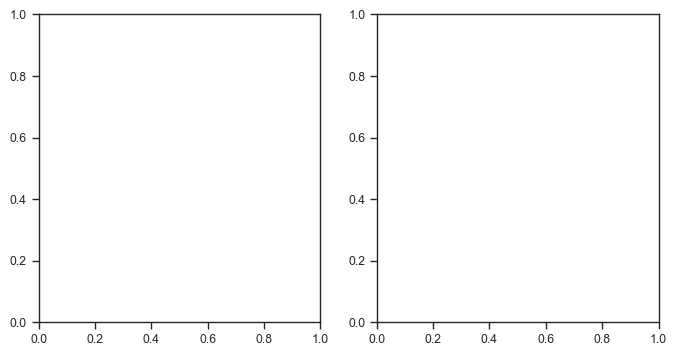

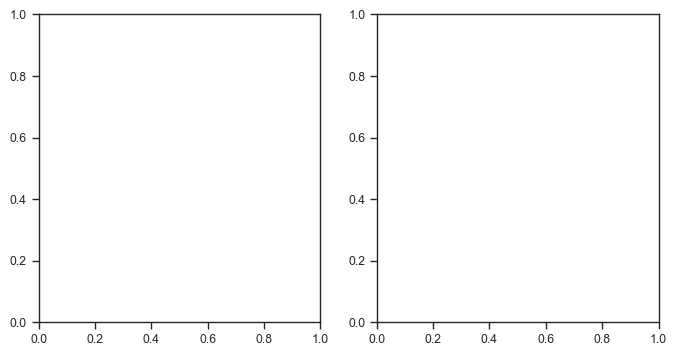

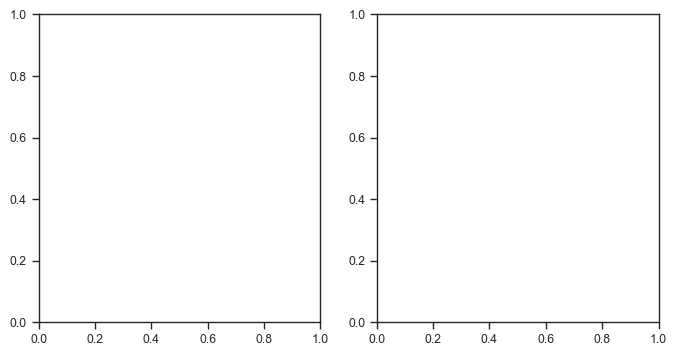

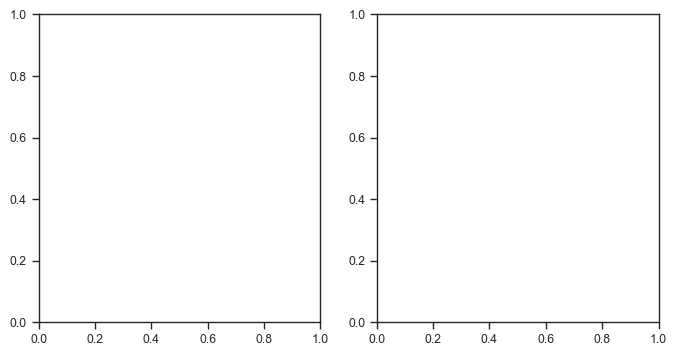

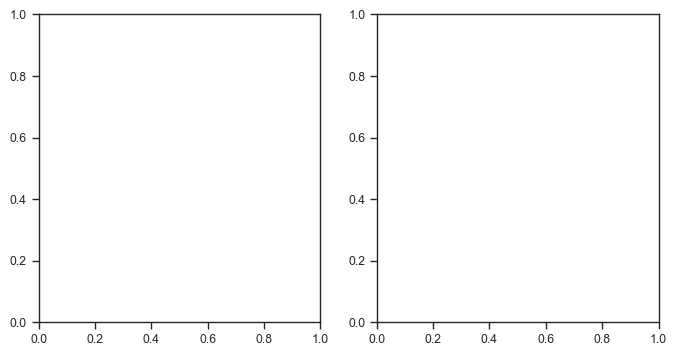

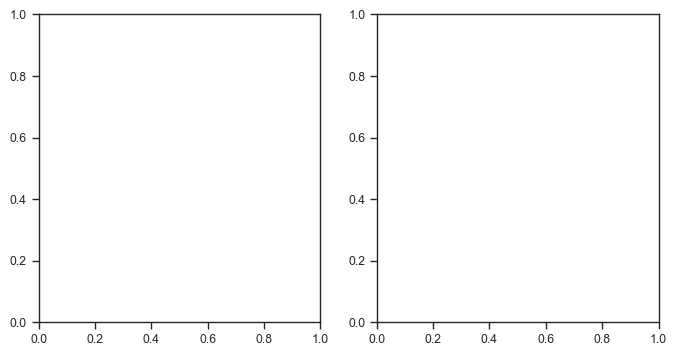

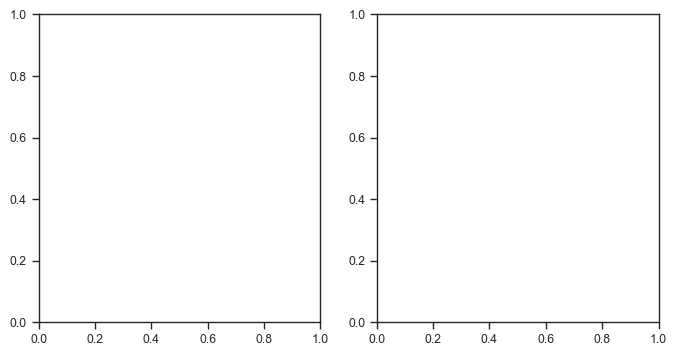

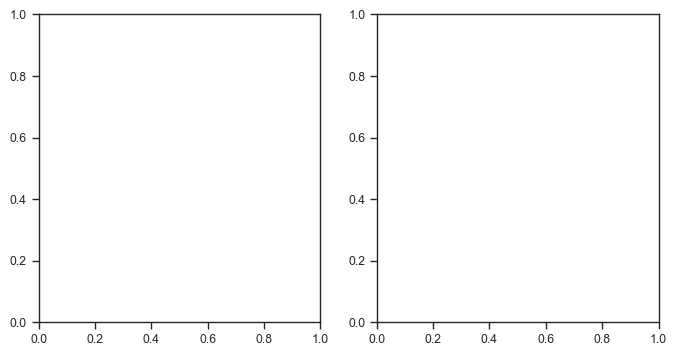

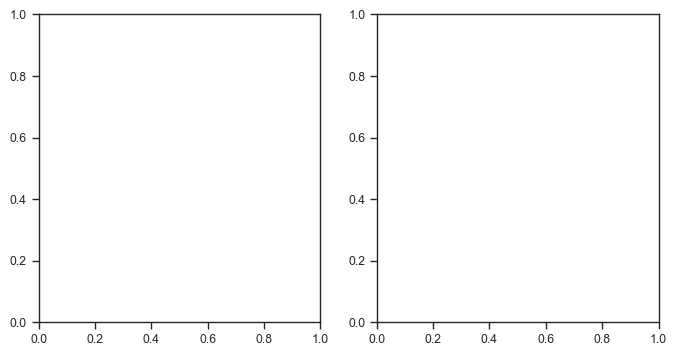

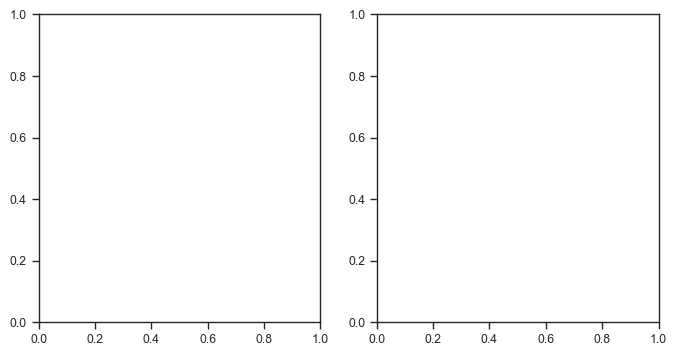

In [9]:
for ratio in myrange:
    config.update(dict(use_train_set_ratio=ratio))
    tnn.model_pipeline(config)

## Run model test only

In [2]:
config = dict(
    use_model_from='json',
    test_mode='val',
)
val_result_df = tnn.test(
    config,
    json_file='./models/dna-nnn-swift-lake-118-adj.json',
    debug=False,
    log_wandb=False,
    save_val_result_df=True
)

In [3]:
val_result_df.to_csv('./models/swift-lake-118-ddX_val_result_df.csv')